In [144]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

ramen = pd.read_csv(r"C:\Users\tyler\Downloads\ramen-ratings.csv")

In [145]:
print(ramen.head())
columns = list(ramen)
print(ramen.describe())
print(ramen.Stars)
print(ramen['Top Ten'].unique())

   Review #           Brand  \
0      2580       New Touch   
1      2579        Just Way   
2      2578          Nissin   
3      2577         Wei Lih   
4      2576  Ching's Secret   

                                             Variety Style Country Stars  \
0                          T's Restaurant Tantanmen    Cup   Japan  3.75   
1  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack  Taiwan     1   
2                      Cup Noodles Chicken Vegetable   Cup     USA  2.25   
3                      GGE Ramen Snack Tomato Flavor  Pack  Taiwan  2.75   
4                                    Singapore Curry  Pack   India  3.75   

  Top Ten  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
          Review #
count  2580.000000
mean   1290.500000
std     744.926171
min       1.000000
25%     645.750000
50%    1290.500000
75%    1935.250000
max    2580.000000
0       3.75
1          1
2       2.25
3       2.75
4       3.75
        ... 
2575     3.5
2576       1
2577     

Generating binary values of the Style column so they can be used in a regression model later on! Binary values are also calculated for the packaging style, as well as the region/continent and  

In [146]:
style_binary_values = pd.get_dummies(ramen.Style)

In [147]:
country_names = ramen.Country.unique()
print(country_names)

def region_assignment(x): 
    if x in ['USA', 'United States', 'Mexico', 'Canada']: 
        return 'North America'
    elif x in ['Colombia', 'Brazil']:
        return 'South America'
    elif x in ['Pakistan', 'Vietnam', 'Japan', 'Taiwan', 'South Korea', 'Singapore', 'Thailand', 
               'Hong Kong', 'Myanmar', 'Nepal', 'Malaysia', 'Singapore', 
               'China', 'Sarawak', 'Phillipines', 'Dubai']:
        return 'Asia'
    elif x in ['Germany', 'Hungary', 'Holland', 'Poland', 'Finland']:
        return 'Europe'
    elif x in ['Ghana']: 
        return 'Africa'
    else: 
        return 'Oceania'
    
ramen['Region'] = ramen.Country.apply(func = region_assignment)

region_values = pd.get_dummies(ramen.Region)

['Japan' 'Taiwan' 'USA' 'India' 'South Korea' 'Singapore' 'Thailand'
 'Hong Kong' 'Vietnam' 'Ghana' 'Malaysia' 'Indonesia' 'China' 'Nigeria'
 'Germany' 'Hungary' 'Mexico' 'Fiji' 'Australia' 'Pakistan' 'Bangladesh'
 'Canada' 'Nepal' 'Brazil' 'UK' 'Myanmar' 'Netherlands' 'United States'
 'Cambodia' 'Finland' 'Sarawak' 'Philippines' 'Sweden' 'Colombia'
 'Estonia' 'Holland' 'Poland' 'Dubai']


In [148]:
def spicy_indicator(x): 
    if 'Spicy' in x or 'Hot' in x: 
        return 1
    else: 
        return 0
def chicken_indicator(x): 
    if 'Chicken' in x: 
        return 1
    else: return 0 
    
def pork_indicator(x):
    if 'Pork' in x: 
        return 1
    else:
        return 0 
    
def beef_indicator(x): 
    if 'Beef' in x or 'Oxtain' in x:
        return 1 
    else: 
        return 0 
    
def other_indicator(x): 
    if 'Chicken' in x:
        return 0 
    elif 'Beef' in x: 
        return 0 
    elif 'Pork' in x: 
        return 0 
    else: 
        return 1

ramen['Spicy'] = ramen.Variety.apply(func = spicy_indicator)
ramen['Chicken'] = ramen.Variety.apply(func = chicken_indicator)
ramen['Beef'] = ramen.Variety.apply(func = beef_indicator)
ramen['Pork'] = ramen.Variety.apply(func = pork_indicator)
ramen['Other'] = ramen.Variety.apply(func = other_indicator)

print('Number of Beef Ramen Products Reviewed:', ramen.Beef.sum())
print('Number of Chicken Ramen Products Reviewed:', ramen.Chicken.sum())
print('Number of Pork Ramen Products Reviewed:', ramen.Pork.sum())
print('Ramen Products Reviewed of Other Flavors:', ramen.Other.sum())

Number of Beef Ramen Products Reviewed: 232
Number of Chicken Ramen Products Reviewed: 323
Number of Pork Ramen Products Reviewed: 102
Ramen Products Reviewed of Other Flavors: 1924


In [149]:
ramen = pd.concat([ramen, style_binary_values, region_values], ignore_index = False, axis=1)
print(list(ramen))

['Review #', 'Brand', 'Variety', 'Style', 'Country', 'Stars', 'Top Ten', 'Region', 'Spicy', 'Chicken', 'Beef', 'Pork', 'Other', 'Bar', 'Bowl', 'Box', 'Can', 'Cup', 'Pack', 'Tray', 'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']


In [150]:
ramen.dtypes

Review #          int64
Brand            object
Variety          object
Style            object
Country          object
Stars            object
Top Ten          object
Region           object
Spicy             int64
Chicken           int64
Beef              int64
Pork              int64
Other             int64
Bar               uint8
Bowl              uint8
Box               uint8
Can               uint8
Cup               uint8
Pack              uint8
Tray              uint8
Africa            uint8
Asia              uint8
Europe            uint8
North America     uint8
Oceania           uint8
South America     uint8
dtype: object

In [151]:
print(ramen.head(10))

   Review #           Brand  \
0      2580       New Touch   
1      2579        Just Way   
2      2578          Nissin   
3      2577         Wei Lih   
4      2576  Ching's Secret   
5      2575   Samyang Foods   
6      2574         Acecook   
7      2573     Ikeda Shoku   
8      2572      Ripe'n'Dry   
9      2571            KOKA   

                                             Variety Style      Country Stars  \
0                          T's Restaurant Tantanmen    Cup        Japan  3.75   
1  Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...  Pack       Taiwan     1   
2                      Cup Noodles Chicken Vegetable   Cup          USA  2.25   
3                      GGE Ramen Snack Tomato Flavor  Pack       Taiwan  2.75   
4                                    Singapore Curry  Pack        India  3.75   
5                             Kimchi song Song Ramen  Pack  South Korea  4.75   
6                Spice Deli Tantan Men With Cilantro   Cup        Japan     4   
7         

0       3.75
1       1.00
2       2.25
3       2.75
4       3.75
        ... 
2575    3.50
2576    1.00
2577    2.00
2578    2.00
2579    0.50
Name: Stars, Length: 2580, dtype: float64
There are 0 null values.


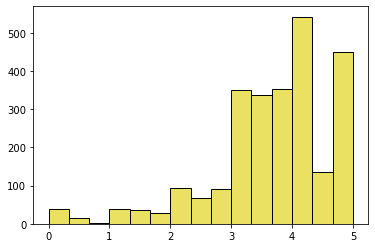

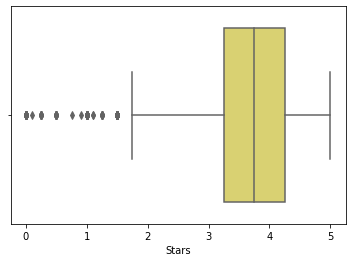

The average rating is 3.65 stars.
The median rating is 3.75 stars.
The standard deviation is 1.02 stars.
The lowest rating is 0.0 stars.
THe highest rating is 5.0 stars.


<Figure size 432x288 with 0 Axes>

In [152]:
ramen.Stars = pd.to_numeric(ramen.Stars, errors = 'coerce')
print(ramen.Stars)
ramen.dropna(subset = ['Stars'], axis = 0, inplace = True)
print("There are", ramen.Stars.isna().sum(), "null values.")

plt.hist(ramen.Stars, bins = 15, color = '#EAE061', edgecolor = 'black')
plt.show()
plt.clf()

sns.boxplot(x = ramen.Stars, color = '#EAE061')
plt.show()
plt.clf()

median_stars = ramen.Stars.median()
mean_stars = ramen.Stars.mean()
std_stars = ramen.Stars.std()


minimum_star_rating = ramen.Stars.min()
maximum_star_rating = ramen.Stars.max()

print("The average rating is", round(mean_stars, 2), "stars.")
print("The median rating is", round(median_stars, 2), "stars.")
print("The standard deviation is", round(std_stars, 2), "stars.")

print("The lowest rating is", round(minimum_star_rating, 2), "stars.")
print("THe highest rating is", round(maximum_star_rating, 2), "stars.")

In [153]:
ramen_reviewers = ramen.Country.unique()
regional_average_rating = ramen.groupby('Region').Stars.mean()
print(regional_average_rating)

Region
Africa           3.500000
Asia             3.746866
Europe           3.622340
North America    3.347756
Oceania          3.518373
South America    3.772727
Name: Stars, dtype: float64


In [154]:
print(ramen.groupby('Region').Region.count())

Region
Africa              2
Asia             1795
Europe             47
North America     390
Oceania           332
South America      11
Name: Region, dtype: int64


In [155]:
print(ramen.groupby('Style').Style.count())

Style
Bar        1
Bowl     481
Box        6
Can        1
Cup      450
Pack    1528
Tray     108
Name: Style, dtype: int64


In [156]:
style_averages = ramen.groupby('Style').Stars.mean()
print(style_averages)

Style
Bar     5.000000
Bowl    3.670686
Box     4.291667
Can     3.500000
Cup     3.498500
Pack    3.700458
Tray    3.545139
Name: Stars, dtype: float64


Now I conducted a multiple linear regression looking at the relationship between the flavor of ramen, the country it was produced, the packaging style of ramen, and the overall rating a reviewer assigns said product, which serves as the dependent variable in this analysis. For each independent variable, a specific variable is left out for reference (in this case, "Oceania," "Other (ramen that's not chicken, beef, or pork)", and "Pack" ramen. 

In [157]:
x = ramen[['Bowl', 'Box', 'Can', 'Cup', 'Bar', 'Tray', 'North America', 'Africa', 'South America', 'Europe', 'Asia', 'Spicy', 'Chicken', 'Beef', 'Pork']]
y = ramen.Stars

x = sm.add_constant(x)

est = sm.OLS(y, x).fit() 
est.summary()

C:\Users\tyler\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6.358
Date:                Mon, 29 Aug 2022   Prob (F-statistic):           1.87e-13
Time:                        22:15:23   Log-Likelihood:                -3648.2
No. Observations:                2577   AIC:                             7328.
Df Residuals:                    2561   BIC:                             7422.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.6151      0.059     61.674      0.000       3.500       3.730
Bowl             -0.0312      0.053     -0.586      0.558      -0.136       0.073
Box               0.6016      0.409      1.470      0.142      -0.201       1.404
Can               0.2528      1.003      0.252      0.801      -1.713       2.219
Cup              -0.1372      0.054     -2.527      0.012      -0.244      -0.031
Bar               1.5192      1.002      1.517      0.129      -0.445       3.483
Tray             -0.0586      0.102     -0.573      0.566      -0.259       0.142
North America    -0.1342      0.077     -1.743      0.082      -0.285       0.017
Africa            0.0652      0.712      0.092      0.927      -1.331       1.462
South America     0.2200      0.307      0.717      0.474      -0.382       0.822
Europe            0.0877      0.156      0.562      0.574      -0.218       0.393
Asia              0.2045      0.061      3.333      0.001       0.084       0.325
Spicy             0.0112      0.059      0.188      0.851      -0.105       0.128
Chicken          -0.2337      0.062     -3.767      0.000      -0.355      -0.112
Beef             -0.1803      0.070     -2.557      0.011      -0.318      -0.042
Pork             -0.2754      0.102     -2.700      0.007      -0.475      -0.075
==============================================================================
Omnibus:                      470.688   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              896.759
Skew:                          -1.110   Prob(JB):                    1.87e-195
Kurtosis:                       4.850   Cond. No.                         66.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
north_america_ratings = ramen.Stars[ramen.Region == 'North America']
south_america_ratings = ramen.Stars[ramen.Region == 'South America']
europe_ratings = ramen.Stars[ramen.Region == 'Europe']
africa_ratings = ramen.Stars[ramen.Region == 'Africa']
asia_ratings = ramen.Stars[ramen.Region == 'Asia']
oceania_ratings = ramen.Stars[ramen.Region == 'Oceania']

f_stat, p_val = f_oneway(north_america_ratings, south_america_ratings, europe_ratings, africa_ratings, asia_ratings, oceania_ratings)

print('f-stat:', f_stat)
print('p_value', p_val)

f-stat: 11.56464674893
p_value 4.564468592903681e-11


In [159]:
tukey = pairwise_tukeyhsd(endog = ramen.Stars, groups = ramen.Region, alpha = 0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
       Africa          Asia   0.2469    0.9  -1.781  2.2748  False
       Africa        Europe   0.1223    0.9 -1.9471  2.1918  False
       Africa North America  -0.1522    0.9 -2.1842  1.8797  False
       Africa       Oceania   0.0184    0.9 -2.0145  2.0513  False
       Africa South America   0.2727    0.9 -1.9306  2.4761  False
         Asia        Europe  -0.1245    0.9 -0.5481   0.299  False
         Asia North America  -0.3991  0.001 -0.5592  -0.239   True
         Asia       Oceania  -0.2285  0.002 -0.3997 -0.0573   True
         Asia South America   0.0259    0.9  -0.841  0.8927  False
       Europe North America  -0.2746 0.4864 -0.7172   0.168  False
       Europe       Oceania   -0.104    0.9 -0.5507  0.3427  False
       Europe South America   0.1504    0.9 -0.8097  1.1104  F